# Feature Extraction using CNN

Here we are attempting to train a small Convolution Neural Network to see if the neural network can extract features that can help us improve our classical algorithms.

We first would like to see if a CNN by itself is able to have good performance. Since we have only a small amount of data, our model is very prone to overfitting. This will become evident as we walk through the notebook.

Then, we would like to see if an overfitted CNN can be improved by classical algorithm by extracting the layers of the CNN as features and use classical algorithms to do the rest. We would also see if classical algorithms can be improved by using CNN. In other words, whether combining classical algorithms and CNN is better than each individually.

In [1]:
import os
import keras
import numpy as np
import sklearn.model_selection as ms
import sklearn.decomposition as decomp
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import librosa
import librosa.display as display

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

## Data loading

First we will load out date into the notebook so we can process them easily

In [4]:
X = np.load('data_mat/X3.npy')
Y = np.load('data_mat/Y3.npy')

In [5]:
print("training X shape is {0}".format(X.shape))
print("training Y shape is {0}".format(Y.shape))

training X shape is (500, 20, 1290)
training Y shape is (500, 5)


To apply the training set to the model easier we have applied MFCC transformations to our data to get a 2D matrix. As you can see from the plots below, there are definitely some differences between the MFCC features of different genres.

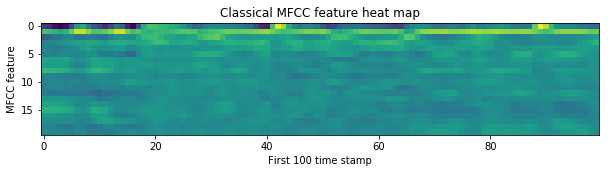

In [6]:
# (0-100) - classical. (200-300) - metal
plt.figure(figsize=(10, 4))
plt.imshow(X[0][:, :100])
plt.xlabel('First 100 time stamp')
plt.ylabel('MFCC feature')
plt.title('Classical MFCC feature heat map')
plt.savefig('plots/classical_mfcc.png')

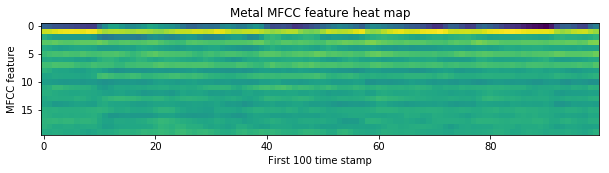

In [7]:
# (0-100) - classical. (200-300) - metal
plt.figure(figsize=(10, 4))
plt.imshow(X[200][:, :100])
plt.xlabel('First 100 time stamp')
plt.ylabel('MFCC feature')
plt.title('Metal MFCC feature heat map')
plt.savefig('plots/metal_mfcc.png')

## Data Splitting

Since we can easily overfit the data, if we split the data independently when training CNN and classical algorithms, we will (and have) end up with very promising results. But in reality we have overfitted the data with our CNN and the overfitted features were mixed into the test set for classical algorithms.

In [ ]:
inds = np.arange(X3.shape[0])
np.random.shuffle(inds)
X_train, X_test, Y_train, Y_test = ms.train_test_split(X3[inds], Y[inds], test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
np.save('extracted/X_test.npy', X_test)
np.save('extracted/X_train.npy', X_train)
np.savetxt('extracted/Y_test.txt', Y_test)
np.savetxt('extracted/Y_train.txt', Y_train)

In [9]:
X_test = np.load('extracted/X_test.npy')
X_train = np.load('extracted/X_train.npy')
Y_test = np.loadtxt('extracted/Y_test.txt')
Y_train = np.loadtxt('extracted/Y_train.txt')

## CNN modeling

Here we have experimented with multiple models, and their results are shown below. The model that we end up with is the following one, with failed experiments following this model.

The architecture is shown below:

<img src="plots/DCNN.png">

Essentially, the final model consists of 2 Dilated Convolutional Neural Network (DCNN) units. First unit consists of a 1D DCNN layer (8 filters of size 64 with dilation rate 8 and "same" padding), followed by an 1D Average pool layer (of size 32) with 50% drop off rate. Then it is followed by a BatchNorm layer that helps with training and also have a slight regularization effect due to its effectiveness against covariate shifting. Then it is passed through a relu activation layer. This unit is followed by the same unit architecutre but with a Dilated Convolution layer of 24 filters of size 16 with dilation rate 2, followed by an 1D Average pool layer (of size 4) with 50% drop off rate. Then it is flattened and connected to a single fully connected layer and outputs a length 5 vector with softmax activation.

Since Dilated Convolutional Neural Network is fairly new, we will draw out a quick representation here:

<img src="plots/DCNN Layer Diagram.png" width=50%>

In the diagram above, we demonstrate a single dilated convolutional layer with filter size 2 and dilation rate 4. (Not the one we used but a good demonstration) The light yellow nodes have 20 channels of MFCC features, and each blue node has number of channels equal to the number of filters used. 

In [38]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    
    X = keras.layers.Conv1D(filters=8, kernel_size=64, dilation_rate=8,
                            padding='same', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Conv1D(filters=24, kernel_size=16, dilation_rate=2, padding='valid', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=4)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Flatten()(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [212]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    
    X = keras.layers.Conv1D(filters=16, kernel_size=64, dilation_rate=8,
                            padding='same', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Conv1D(filters=64, kernel_size=16, dilation_rate=2, padding='valid', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=4)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Flatten()(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [213]:
m = model(X_train.shape[1:])
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [214]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 1290, 20)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 1290, 16)          20496     
_________________________________________________________________
dropout_62 (Dropout)         (None, 1290, 16)          0         
_________________________________________________________________
average_pooling1d_42 (Averag (None, 40, 16)            0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 40, 16)            64        
_________________________________________________________________
activation_54 (Activation)   (None, 40, 16)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 10, 64)            16448     
__________

In [221]:
# %%capture
m.fit(X_train, Y_train, epochs=50, batch_size=64)

Epoch 1/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0841 - categorical_accuracy: 0.9750
Epoch 2/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0911 - categorical_accuracy: 0.9825
Epoch 3/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0764 - categorical_accuracy: 0.9850
Epoch 4/50
400/400 [==============================] - 2s 4ms/step - loss: 0.0938 - categorical_accuracy: 0.9750
Epoch 5/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0770 - categorical_accuracy: 0.9875
Epoch 6/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0660 - categorical_accuracy: 0.9875
Epoch 7/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0567 - categorical_accuracy: 0.9875
Epoch 8/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0458 - categorical_accuracy: 0.9925
Epoch 9/50
400/400 [==============================] - 2s 5ms/step - loss: 0.0392 - categorical_accuracy:

In [222]:
preds = m.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

400/400 [==============================] - 1s 2ms/step
Loss = 0.014776835441589356
Train Accuracy = 1.0


In [223]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 2ms/step
Loss = 0.511816325187683
Test Accuracy = 0.84


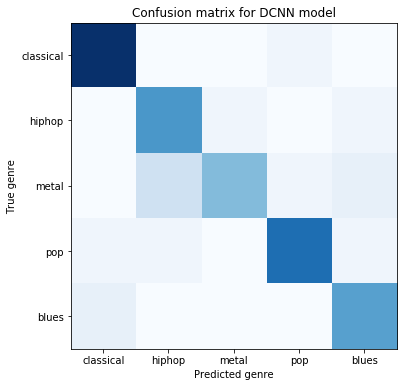

In [184]:
plt.figure(figsize=(6, 6))
cm = metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.yticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.title('Confusion matrix for DCNN model')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
plt.savefig('plots/dcnn_confusion.png')
plt.show()

In [159]:
m.save('saved_models/dcnn_best.h5')

In [73]:
m = keras.models.load_model('saved_models/dcnn_best.h5')

### Failed Experiments and Models

Here are some of our failed models and why we suspect they failed. Here we are only concerned about the architecture of the model and not the hyper parameters since we have tuned the hyper parameters to be as optimal as it can.

The first model that we tried and failed is a very basic CNN model with 1 layer CNN, max pool, and 2 layer fully connected. We actually used this model as a baseline.

In [58]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    
    X = keras.layers.Conv1D(filters=8, kernel_size=64,
                            padding='same', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.MaxPooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(10, activation='softmax')(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [59]:
m = model(X_train.shape[1:])
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1290, 20)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1290, 8)           10248     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1290, 8)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 8)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 40, 8)             32        
_________________________________________________________________
activation_7 (Activation)    (None, 40, 8)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 320)               0         
__________

In [63]:
%%capture
m.fit(X_train, Y_train, epochs=100, batch_size=64)

In [64]:
preds = m.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

400/400 [==============================] - 0s 1ms/step
Loss = 0.8829513716697693
Train Accuracy = 0.8475


In [65]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 1ms/step
Loss = 0.9334834337234497
Test Accuracy = 0.78


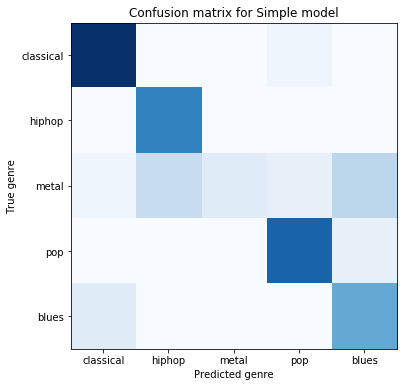

In [66]:
plt.figure(figsize=(6, 6))
cm = metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.yticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.title('Confusion matrix for Simple model')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
plt.show()

As you can see above, the metal genre was classified as, well, everything...

We then attempted to improve our model by switching out convolution layer with a dilated convolution layer. Dilation allows us to see a wider range of data in our first layer.

In [67]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    
    X = keras.layers.Conv1D(filters=8, kernel_size=64, dilation_rate=8,
                            padding='same', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.MaxPooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(10, activation='softmax')(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [68]:
m = model(X_train.shape[1:])
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1290, 20)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1290, 8)           10248     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1290, 8)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 40, 8)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 40, 8)             32        
_________________________________________________________________
activation_8 (Activation)    (None, 40, 8)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
__________

In [69]:
%%capture
m.fit(X_train, Y_train, epochs=100, batch_size=64)

In [70]:
preds = m.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

400/400 [==============================] - 1s 2ms/step
Loss = 0.9825398397445678
Train Accuracy = 0.94


In [71]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 1ms/step
Loss = 1.0883744621276856
Test Accuracy = 0.8


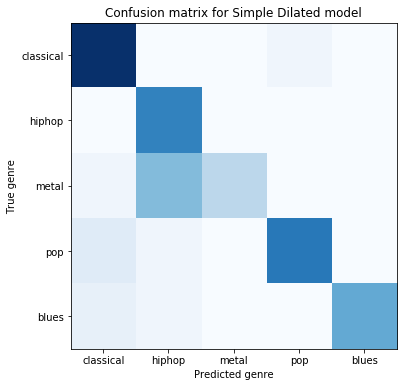

In [72]:
plt.figure(figsize=(6, 6))
cm = metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.yticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.title('Confusion matrix for Simple Dilated model')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
plt.show()

Test accuracy has improved but we are still doing poorly on metal. What is wrong with that huh?

Next we tried to improve the model by switching out the max pool layer with an average pool layer. We suspect that since the window of pooling is so big, a max pool would have gotten rid of a lof of information.

In [73]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    
    X = keras.layers.Conv1D(filters=8, kernel_size=64,
                            padding='same', data_format="channels_last")(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.AveragePooling1D(pool_size=32)(X)
    X = keras.layers.BatchNormalization(axis = 2)(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(10, activation='softmax')(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(5, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

In [74]:
m = model(X_train.shape[1:])
m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1290, 20)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1290, 8)           10248     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1290, 8)           0         
_________________________________________________________________
average_pooling1d_7 (Average (None, 40, 8)             0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 40, 8)             32        
_________________________________________________________________
activation_9 (Activation)    (None, 40, 8)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 320)               0         
__________

In [75]:
%%capture
m.fit(X_train, Y_train, epochs=100, batch_size=64)

In [76]:
preds = m.evaluate(X_train, Y_train)
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

400/400 [==============================] - 1s 2ms/step
Loss = 0.7373093557357788
Train Accuracy = 0.94


In [77]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

100/100 [==============================] - 0s 1ms/step
Loss = 0.8886743450164795
Test Accuracy = 0.81


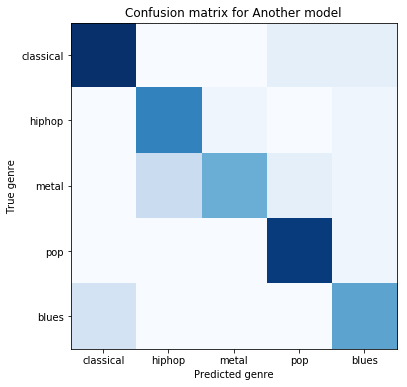

In [78]:
plt.figure(figsize=(6, 6))
cm = metrics.confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(m.predict(X_test), axis=-1))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.yticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.title('Confusion matrix for Another model')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
plt.show()

Test accuracy has improved. Hey at least we can recognize metal properly right? 

The last thing that we tried is the best model that we came up with in the beginning of the section, by swapping out the dense layer with a second convolution layer. 

### Feature extraction

Now that we have found a DCNN model that perform reasonably well, we will now attempt to extract features from this model and use it as inputs to the classical algorithms. Here, since we have 2 units we will extract the activations of these two units by passing in our training and test data as inputs, and collect the activations from these 2 units. More specifically, we will get the activation values after the first relu layer, and the flattened layer.

In [185]:
model = m

In [186]:
print(model.layers[5], model.layers[11])

<keras.layers.core.Activation object at 0x153c7afd0> <keras.layers.core.Flatten object at 0x153e84ac8>


In [187]:
def extract_all_features(X, model, layer_nums, batch_num):
    """Extract all the features by taking out the activation output of the layers specified in layer_nums
    
        X : the data that we are trying to extract features from
        model: the model that we are using to extract the features
        layer_nums: the layer number that we want to use as feature extractors
    """
    outputs = [model.layers[layer].output for layer in layer_nums]
    f = keras.backend.function([model.input, keras.backend.learning_phase()], outputs)
    ## split up into smaller chunks
    layer_outs = []
    m = X.shape[0]
    for i in range(batch_num):
        layer_outs += [f([X[(m // batch_num * i):(m // batch_num * (i+1)), :, :], 0.])]
    result = []
    for i in range(len(layer_nums)):
        layer_outs2 = []
        for batch in range(batch_num):
            activations = layer_outs[batch][i]
            activations = activations.reshape(activations.shape[0], -1)
            layer_outs2 += [activations]
        result += [np.vstack(np.array(layer_outs2))]
    return result

In [188]:
layer_outs_train = extract_all_features(X_train, model, [5, 11], 10)

In [189]:
layer_outs_test = extract_all_features(X_test, model, [5, 11], 1)

In [190]:
conv_1_train, conv_2_train = layer_outs_train
conv_1_test, conv_2_test = layer_outs_test
np.savetxt('extracted/conv_1_train.txt', conv_1_train)
np.savetxt('extracted/conv_2_train.txt', conv_2_train)
np.savetxt('extracted/conv_1_test.txt', conv_1_test)
np.savetxt('extracted/conv_2_test.txt', conv_2_test)

## PCA

Since we have extracted the layers as features, one thing we are interested in is seeing how well the layers capture the real features of the music. To do this, we will run PCA and reduce the features into 3 dimensional space. This will show us visually how well the features capture the information about the music.

In [99]:
X_train = np.load('extracted/X_train.npy')
X_test = np.load('extracted/X_test.npy')
Y_train = np.loadtxt('extracted/Y_train.txt')
Y_test = np.loadtxt('extracted/Y_test.txt')
conv_2_train = np.loadtxt('extracted/conv_2_train.txt')
conv_1_train = np.loadtxt('extracted/conv_1_train.txt')
conv_2_test = np.loadtxt('extracted/conv_2_test.txt')
conv_1_test = np.loadtxt('extracted/conv_1_test.txt')

Since raw MFCC features were used as baseline, we are interested to see how well those "features" explain our data. The code below generates the PCA of the basic MFCC features.

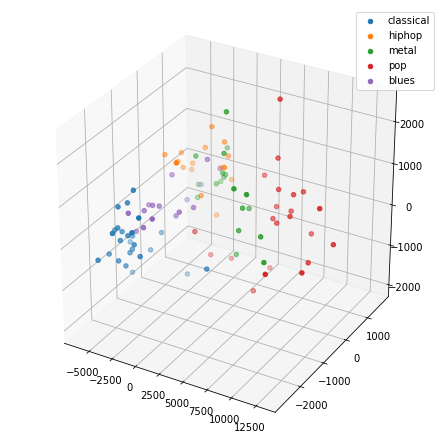

In [191]:
pca_conv = decomp.PCA(3)
pca_conv.fit(X_train.reshape(X_train.shape[0], -1))
test_pca = pca_conv.transform(X_test.reshape(X_test.shape[0], -1))
colors = np.argmax(Y_test, axis=1)
colors_txt = np.empty(len(colors), dtype=str)
colors_txt[colors==0] = 'red'
colors_txt[colors==1] = 'blue'
colors_txt[colors==2] = 'green'
colors_txt[colors==3] = 'yellow'
colors_txt[colors==4] = 'black'
genres = ['classical', 'hiphop', 'metal', 'pop', 'blues']
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
for i in range(5):
    ax.scatter(test_pca[colors==i, 0].ravel(), test_pca[colors==i,1].ravel(), test_pca[colors==i,2].ravel(),
                label=genres[i])
ax.legend()
plt.savefig('plots/mfcc_pca.png')
plt.show()

As you can see from the plot above, there are some vague clusters seen in plot but they are fairly close to each other and it is hard to make out easily which class is where. 

Then, we will use PCA to reduce the dimension of the first convolution layer's activation to 3 dimensions so we can visualize them.

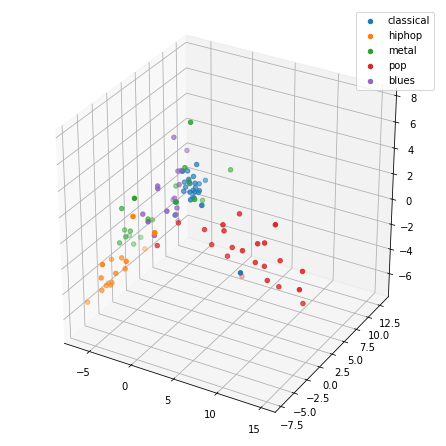

In [193]:
pca_conv = decomp.PCA(3)
pca_conv.fit(conv_1_train)
test_pca = pca_conv.transform(conv_1_test)
colors = np.argmax(Y_test, axis=1)
colors_txt = np.empty(len(colors), dtype=str)
colors_txt[colors==0] = 'red'
colors_txt[colors==1] = 'blue'
colors_txt[colors==2] = 'green'
colors_txt[colors==3] = 'yellow'
colors_txt[colors==4] = 'black'
genres = ['classical', 'hiphop', 'metal', 'pop', 'blues']
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
for i in range(5):
    ax.scatter(test_pca[colors==i, 0].ravel(), test_pca[colors==i,1].ravel(), test_pca[colors==i,2].ravel(),
                label=genres[i])
ax.legend()
plt.savefig('plots/conv_1_pca.png')
plt.show()

As we can clearly see from the plot above, the first 2 dimensions separates the pop genre very well from the rest of the genres. And the rest of the genres are clustered much more closely to each other than before (even though metal is still all over the place). Ideally we would like to visualize the PCA reduced to 5 dimensions because we have 5 classes but it seems impossible to visualize a 5D array.

Next we will plot the PCA of the second layer, which is the one closest to the output

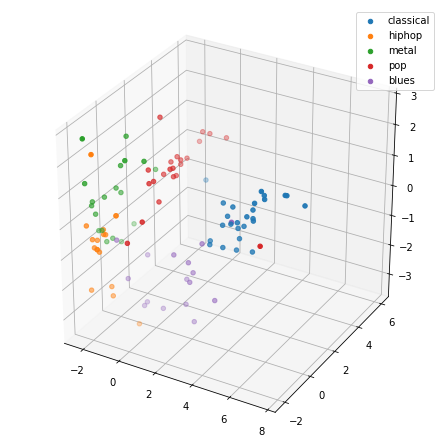

In [192]:
pca_conv = decomp.PCA(3)
pca_conv.fit(conv_2_train)
test_pca = pca_conv.transform(conv_2_test)
colors = np.argmax(Y_test, axis=1)
colors_txt = np.empty(len(colors), dtype=str)
colors_txt[colors==0] = 'red'
colors_txt[colors==1] = 'blue'
colors_txt[colors==2] = 'green'
colors_txt[colors==3] = 'yellow'
colors_txt[colors==4] = 'black'
genres = ['classical', 'hiphop', 'metal', 'pop', 'blues']
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
for i in range(5):
    ax.scatter(test_pca[colors==i, 0].ravel(), test_pca[colors==i,1].ravel(), test_pca[colors==i,2].ravel(),
                label=genres[i])
ax.legend()
plt.savefig('plots/conv_2_pca.png')
plt.show()

As you can see, the groups are more clustered together, even metal that was notoriously spread out throughout other genres are now closely grouped together (still overlapping with blues though). However, it is a little hard to see since this is in 3 dimension but I do believe they are fairly separated from each other because the shade of the color indicates how close it is to us. 

# Conclusion

We have seen in this notebook that we have run several experiments iteratively improving the architecture that we had before. We have tried to address overfitting by using Batch Norm and dropout but still it overfits our training set in all the model considered. Still, the model performed reasonably well and the PCA analysis of the features extracted using the CNN shows that the features do capture quite a bit of information about the music. Next step we will run the classical algorithm again and see how they do.